In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.manual_seed(42)

In [ ]:
batch_size = 8                      # b, b_sz
context_len = 1024                  # seq_len, context_length, num_tokens, t, n_tokens
d_model = 768                       # embed_dim, d_in, d_out, d
n_heads = 6                         # h
n_groups = 2                        # g
head_dim = d_model // n_heads       # d_k, d_v

In [ ]:
x = torch.randn((batch_size, context_len, d_model), device=device)

# Multi-Head Attention (MHA)

Vaswani, Ashish, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. “Attention Is All You Need.” arXiv, 2017. https://doi.org/10.48550/arXiv.1706.03762.

$$
\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V
$$

In [ ]:
class Head(nn.Module):
    def __init__(self, d_model: int, d_out: int, context_length: int, attn_dropout: float = 0.0, qkv_bias: bool = False) -> None:
        super().__init__()

        self.key = nn.Linear(d_model, d_out, bias = qkv_bias)
        self.query = nn.Linear(d_model, d_out, bias = qkv_bias)
        self.value = nn.Linear(d_model, d_out, bias = qkv_bias)

        # casual mask (another solution)
        # self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length)))

        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, query, key, value, attn_mask = None, padding_mask = None) -> torch.Tensor:

        # b, t, d_model = x.shape

        q = self.query(query)   # (b, t, d_k)
        k = self.key(key)       # (b, t, d_k)
        v = self.value(value)   # (b, t, d_v)

        # (b, t, t) = (b, t, d) @ (b, d, t)
        attn_scores = q @ k.transpose(1, 2)

        # casual mask (t, t)
        if attn_mask is not None:
            # attn_scores.masked_fill_(self.mask.bool()[:t, :t], -torch.inf)
            attn_scores.masked_fill_(attn_mask, -torch.inf) # casual attention (set all true positions to -inf)

        attn_weights = torch.softmax(attn_scores / k.shape[-1]**0.5, dim=-1)

        attn_weights = self.dropout(attn_weights)

        context_vec = attn_weights @ v

        return context_vec

$$
\operatorname{MultiHead}(X_Q, X_K, X_V) = \operatorname{Concat}\left(\operatorname{head}_1, \ldots, \operatorname{head}_{\mathrm{h}}\right) W^O
$$


$$
\quad \quad \quad \operatorname{head}_i = \operatorname{Attention} \left(X_Q W_i^Q, X_K W_i^K, X_V W_i^V \right)
$$

where,
- $W_i^Q \in \mathbb{R}^{d_{\text {model }} \times d_k}$,
- $W_i^K \in \mathbb{R}^{d_{\text {model }} \times d_k}$,
- $W_i^V \in \mathbb{R}^{d_{\text {model }} \times d_v}$,
- $W^O \in \mathbb{R}^{h d_v \times d_{\text {model }}}$.

For each of these we use $d_k = d_v = \frac{d_{model}}{h}$.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, h: int, context_length: int, attn_dropout: float = 0.0, qkv_bias: bool = False):
        super().__init__()

        assert d_model % n_heads == 0, "d_model is indivisible by n_heads"

        self.d_out = d_model // h # = d_k = d_v

        self.heads = nn.ModuleList(
            [ Head(d_model, self.d_out, context_length, attn_dropout, qkv_bias) for _ in range(h) ]
        )
        self.w_o = nn.Linear(n_heads * self.d_out, d_model) # out_proj

    def forward(self, query, key, value, attn_mask, padding_mask = None):
        out = torch.cat([head(query, key, value, attn_mask, padding_mask) for head in self.heads], dim=-1)
        out = self.w_o(out)
        return out

In [ ]:
mha = MultiHeadAttention(d_model, n_heads, context_len).to(device)

In [ ]:
result = mha(x, x, x, attn_mask=None)
result.shape # (batch_size, num_tokens, d_model)

torch.Size([8, 1024, 768])

### MHA with Combined QKV

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model: int, h: int, dropout = 0.0, qkv_bias = False):
        super().__init__()

        assert d_model % h == 0, "d_model is indivisible by h (number of heads)"

        self.h = h
        self.d_model = d_model
        self.d_out = d_model // h # d_v, d_k

        self.qkv = nn.Linear(d_model, 3 * self.d_model, bias = qkv_bias)

        self.proj = nn.Linear(h * self.d_out, d_model)


    def forward(self, x: torch.Tensor):

        b, t, d_model = x.shape

        qkv = self.qkv(x) # (b, t, 3 * d_out)

        qkv = qkv.view(b, t, 3, self.h, self.d_out)

        qkv = qkv.permute(2, 0, 3, 1, 4) # (3, b, h, t, d_out)

        queries, keys, values = qkv.unbind(0) # 3 x (b, h, t, d_out)

        # (b, h, t, t) = (b, h, t, d_out) @ (b, h, d_out, t)
        attn_scores = queries @ keys.transpose(-2, -1)

        attn_weights = torch.softmax(attn_scores / math.sqrt(self.d_out), dim = -1)

        # (b, h, t, d_out) = (b, h, t, t) @ (b, h, t, head_dim)
        context_vec = attn_weights @ values

        # (b, t, h, d_out) <- (b, h, t, d_out)
        context_vec = context_vec.transpose(1, 2).contiguous()

        context_vec = context_vec.contiguous().view(b, t, d_model)

        context_vec = self.proj(context_vec)

        return context_vec

In [ ]:
mha = MultiHeadAttention(d_model, n_heads).to(device)

In [ ]:
mha(x).shape # (batch_size, num_tokens, d_model)

torch.Size([8, 1024, 768])

### FlexAttention

FlexAttention: The Flexibility of PyTorch with the Performance of FlashAttention https://pytorch.org/blog/flexattention/

# Multi-Query Attention (MQA)

Shazeer, Noam. “Fast Transformer Decoding: One Write-Head Is All You Need.” arXiv, November 6, 2019. https://doi.org/10.48550/arXiv.1911.02150.


$$
\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V
$$

$$
\operatorname{MultiHead}(X_Q, X_K, X_V) = \operatorname{Concat}\left(\operatorname{head}_1, \ldots, \operatorname{head}_{\mathrm{h}}\right) W^O
$$

$$
\quad \quad \quad \operatorname{head}_i = \operatorname{Attention} \left(X_Q W_i^Q, X_K W^K, X_V W^V \right)
$$

where,
- $W_i^Q \in \mathbb{R}^{d_{\text {model }} \times d_k}$,
- $W^K \in \mathbb{R}^{d_{\text {model }} \times d_k}$,
- $W^V \in \mathbb{R}^{d_{\text {model }} \times d_v}$,
- $W^O \in \mathbb{R}^{h d_v \times d_{\text {model }}}$.

For each of these we use $d_k = d_v = \frac{d_{model}}{h}$.

In [ ]:
class MultiQueryAttention(nn.Module):

    def __init__(self, d_model: int, h: int):
        super().__init__()

        assert d_model % h == 0, "d_model is indivisible by h (number of heads)"

        self.d_model = d_model
        self.h = h
        self.d_k = self.d_v = d_model // h

        self.q_proj = nn.Linear(d_model, h * self.d_k)
        self.k_proj = nn.Linear(d_model, self.d_k)
        self.v_proj = nn.Linear(d_model, self.d_v)

        self.out_proj = nn.Linear(h * self.d_v, d_model)

    def forward(self, x: torch.Tensor):

        b, t, d_model = x.shape

        q = self.q_proj(x).view(b, self.h, t, self.d_k)
        k = self.k_proj(x).view(b, 1, t, self.d_k)
        v = self.v_proj(x).view(b, 1, t, self.d_v)

        k = k.repeat_interleave(self.h, dim=1)
        v = v.repeat_interleave(self.h, dim=1)

        # (b, h, t, t) = (b, h, t, d_k) @ (b, h, d_k, t)
        attn_scores = torch.matmul(q, k.transpose(2, 3))

        attn_weights = torch.softmax(attn_scores / math.sqrt(self.d_k), dim=-1)

        # (b, h, t, d_v) = (b, h, t, t) @ (b, h, t, d_v)
        # (b, t, h, d_v) <- (b, h, t, d_v)
        context = torch.matmul(attn_weights, v).transpose(1, 2).contiguous()

        context = context.view(b, t, self.d_model)

        return self.out_proj(context)

In [ ]:
mqa = MultiQueryAttention(d_model, n_heads).to(device)

In [ ]:
mqa(x).shape # (batch_size, num_tokens, d_model)

torch.Size([8, 1024, 768])

# Grouped-query attention (GQA)

Ainslie, Joshua, James Lee-Thorp, Michiel de Jong, Yury Zemlyanskiy, Federico Lebrón, and Sumit Sanghai. “GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints.” arXiv, December 23, 2023. https://doi.org/10.48550/arXiv.2305.13245.


$$
\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V
$$

$$
\operatorname{MultiHead}(X_Q, X_K, X_V) = \operatorname{Concat}\left(\operatorname{head}_1, \ldots, \operatorname{head}_{\mathrm{h}}\right) W^O
$$

$$
\quad \quad \quad \operatorname{head}_i = \operatorname{Attention} \left(X_Q W_i^Q, X_K W^K_{g(i)}, X_V W^V_{g(i)} \right)
$$

Divide $i$ into groups of size $m$, that is:
$$
g(i) =\left\lfloor\frac{i}{m}\right\rfloor
$$

$$\therefore$$
$$
0 = g(0)=g(1)=\cdots=g(m-1)
$$
$$
1 = g(m)=g(m+1)=\cdots=g(2m-1)
$$
$$
\vdots
$$

where,
- $W_i^Q \in \mathbb{R}^{d_{\text {model }} \times d_k}$,

- $W_{g(i)}^K \in \mathbb{R}^{d_{\text {model }} \times d_k}$,
- $W_{g(i)}^V \in \mathbb{R}^{d_{\text {model }} \times d_v}$,

- $W^O \in \mathbb{R}^{h d_v \times d_{\text {model }}}$.

For each of these we use $d_k = d_v = \frac{d_{model}}{h}$.

In [ ]:
class GroupedQueryAttention(nn.Module):
    def __init__(self, d_model: int, h: int, n_groups: int, qkv_bias:bool=False):
        super().__init__()

        assert d_model % h == 0, "d_model is indivisible by n_heads"

        self.d_model = d_model
        self.h = h
        self.d_k = self.d_v = d_model // h

        self.g = n_groups
        self.g_size = h // n_groups

        self.q_proj = nn.Linear(d_model, self.h * self.d_k, bias = qkv_bias)
        self.k_proj = nn.Linear(d_model, self.g * self.d_k, bias = qkv_bias)
        self.v_proj = nn.Linear(d_model, self.g * self.d_v, bias = qkv_bias)

        self.out_proj = nn.Linear(self.h * self.d_v, d_model)

    def forward(self, x: torch.Tensor):

        b, t, d  = x.shape

        q = self.q_proj(x).view(b, self.h, t, self.d_k)
        k = self.k_proj(x).view(b, self.g, t, self.d_k)
        v = self.v_proj(x).view(b, self.g, t, self.d_v)

        k = k.repeat_interleave(self.g_size, dim=1)
        v = v.repeat_interleave(self.g_size, dim=1)

        # (b, h, t, t) = (b,  h, t, d_k) x (b, h, d_k, t)
        attn_scores = torch.matmul(q, k.transpose(2, 3)) / math.sqrt(self.d_k)

        attn_weights = F.softmax(attn_scores, dim=-1)

        # (b, t, h, d_v) <- (b, h, t, d_v) = (b, h, t, t) x (b, h, t, d_v)
        context = torch.matmul(attn_weights, v).transpose(1, 2).contiguous()

        context = context.view(batch_size, t, self.d_model)

        return self.out_proj(context)

In [ ]:
gqa = GroupedQueryAttention(d_model, n_heads, 2).to(device)

In [ ]:
gqa(x).shape # (batch_size, num_tokens, d_model)

torch.Size([8, 1024, 768])

# Multi-head Latent Attention (MLA)

DeepSeek-AI, Aixin Liu, Bei Feng, Bin Wang, Bingxuan Wang, Bo Liu, Chenggang Zhao, et al. “DeepSeek-V2: A Strong, Economical, and Efficient Mixture-of-Experts Language Model.” arXiv, June 19, 2024. https://doi.org/10.48550/arXiv.2405.04434.


Let $n_h$ the number of attention heads and $i \in\left\{1,2, \ldots, n_h\right\}$, $d$ be the embedding dimension, $d_h$ be the dimension per head, and $\mathbf{h}_t \in \mathbb{R}^d$ be the attention input of the $t$-th token at an attention layer.

$$
\begin{aligned}
& {\left[\mathbf{q}_{t, 1} ; \mathbf{q}_{t, 2} ; \ldots ; \mathbf{q}_{t, n_h}\right]=\mathbf{q}_t,} \\
& {\left[\mathbf{k}_{t, 1} ; \mathbf{k}_{t, 2} ; \ldots ; \mathbf{k}_{t, n_h}\right]=\mathbf{k}_t,} \\
& {\left[\mathbf{v}_{t, 1} ; \mathbf{v}_{t, 2} ; \ldots ; \mathbf{v}_{t, n_h}\right]=\mathbf{v}_t,}
\end{aligned}
$$

$$
\mathbf{o}_{t, i}=\sum_{j=1}^t \operatorname{Softmax}_j\left(\frac{\mathbf{q}_{t, i}^T \mathbf{k}_{j, i}}{\sqrt{d_h}}\right) \mathbf{v}_{j, i}
$$

$$
\mathbf{u}_t=W^O\left[\mathbf{o}_{t, 1} ; \mathbf{o}_{t, 2} ; \ldots ; \mathbf{o}_{t, n_h}\right],
$$

where
- $\mathbf{q}_{t, i} \in \mathbb{R}^{d_h}$
- $\mathbf{k}_{t, i} \in \mathbb{R}^{d_h}$
- $\mathbf{v}_{t, i} \in \mathbb{R}^{d_h}$
- $W^O \in \mathbb{R}^{d \times d_h n_h}$

The idea of MLA is the **low-rank joint compression** for keys and values to _reduce KV cache_ and for queries. That is, creating down-projection and up-projection matrices and sharing the down-projection matrix for key and values.

$$
\begin{aligned}
\mathbf{c}_t^{K V} & =W^{D K V} \mathbf{h}_t, \\
\mathbf{k}_t^C & =W^{U K} \mathbf{c}_t^{K V}, \\
\mathbf{v}_t^C & =W^{U V} \mathbf{c}_t^{K V},
\end{aligned}
$$

where,
- $\mathbf{c}_t^{K V} \in \mathbb{R}^{d_c}$ and $d_c\left(\ll d_h n_h\right)$
- $W^{D K V} \in \mathbb{R}^{d_c \times d}$
- $W^{U K}, W^{U V} \in \mathbb{R}^{d_h n_h \times d_c}$.

$$
\mathbf{c}_t^Q=W^{D Q} \mathbf{h}_t
$$
$$
\mathbf{q}_t^C=W^{U Q} \mathbf{c}_t^Q
$$

where
- $\mathbf{c}_t^Q \in \mathbb{R}^{d_c^{\prime}}$ and $d_c^{\prime}\left(\ll d_h n_h\right)$,
- $W^{D Q} \in \mathbb{R}^{d_c^{\prime} \times d}$,
- $W^{U Q} \in \mathbb{R}^{d_h n_h \times d_c^{\prime}}$

## Training

In [ ]:
class MultiHeadLatentAttention(nn.Module):
    def __init__(self, d_model: int, n_h: int, d_cq: int = 12, d_c: int = 4):
        super().__init__()

        self.d_model = d_model
        self.n_h = n_h          # n_heads
        self.d_c = d_c          # d_c (<< d_h * n_h)
        self.d_cq = d_cq        # d_c' (<< d_h * n_h)

        self.d_h = d_model // n_heads

        # down-projection matrices
        self.w_dq = nn.Linear(d_model, d_cq)
        self.w_dkv = nn.Linear(d_model, d_c)

        # up-projection matrices
        self.w_uq = nn.Linear(d_cq, n_h * self.d_h)
        self.w_uk = nn.Linear(d_c, n_h * self.d_h)
        self.w_uv = nn.Linear(d_c, n_h * self.d_h)

        self.w_o = nn.Linear(n_heads * self.d_h, d_model) # out proj

    def forward(self, x: torch.Tensor):

        b, t, d_model = x.shape

        # compression
        c_q = self.w_dq(x)     # (b, t, d_c')
        c_kv = self.w_dkv(x)   # (b, t, d_c)

        # decompression
        q_c = self.w_uq(c_q).view(b, self.n_h, t, self.d_h)
        k_c = self.w_uk(c_kv).view(b, self.n_h, t, self.d_h)
        v_c = self.w_uv(c_kv).view(b, self.n_h, t, self.d_h)

        # (b, h, t, t) = (b, h, t, d_h) x (b, h, d_h, t)
        attn_scores = torch.matmul(q_c, k_c.transpose(2, 3)) / math.sqrt(self.d_h)

        attn_weight = torch.softmax(attn_scores, dim=-1)

        # (b, t, h, d_h) <- (b, h, t, d_h) = (b, h, t, t) x (b, h, t, d_h)
        context = torch.matmul(attn_weight, v_c).transpose(1,2).contiguous()

        context = context.view(b, t, self.d_model)

        return self.w_o(context)

In [ ]:
mla = MultiHeadLatentAttention(d_model, n_heads, 2).to(device)

In [ ]:
mla(x).shape # (batch_size, num_tokens, d_model)

torch.Size([8, 1024, 768])

# Speed comparison

In [ ]:
attention_fns = {
    "mha": mha,
    "mqa": mqa,
    "gqa": gqa,
    "mla": mla
}

In [ ]:
def time_pytorch_function(func, *input, num_repeats=1_000):

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    for _ in range(5):
        func(*input)
    torch.cuda.synchronize()

    times = []
    for _ in range(num_repeats):
        start.record()
        func(*input)
        end.record()
        torch.cuda.synchronize()
        times.append(start.elapsed_time(end))

    return np.mean(times), np.std(times)

In [ ]:
stats = [time_pytorch_function(fn, x, num_repeats=100) for fn in attention_fns.values()]

In [ ]:
execution_means = [stat[0] for stat in stats]
execution_stds = [stat[1] for stat in stats]

In [ ]:
def plot_execution_times(functions, execution_means, execution_stds):

    fig, ax = plt.subplots()
    bars = ax.bar(functions.keys(), execution_means, yerr=execution_stds, capsize=5, error_kw={'ecolor': 'grey'})

    plt.ylabel("Execution time (ms)")
    plt.xticks(rotation=45, ha="right")

    max_execution_time = max(execution_means)
    upper_ylim = max_execution_time + 0.4 * max_execution_time
    plt.ylim(0, upper_ylim)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + (0.05 * upper_ylim), round(yval, 2), ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

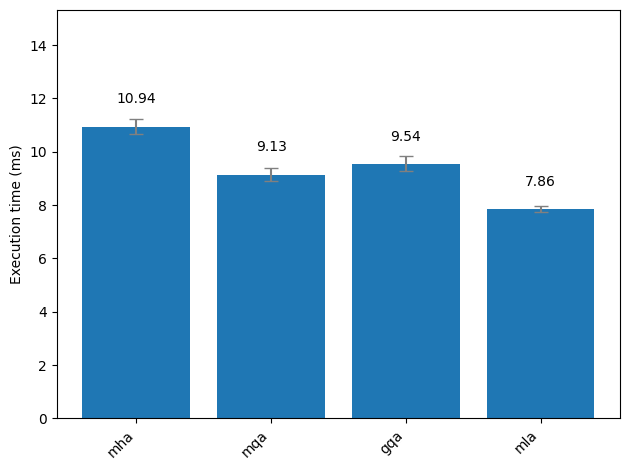

In [ ]:
plot_execution_times(attention_fns, execution_means, execution_stds)